In [1]:
from IPython import get_ipython


def type_of_script():
    """
    Detects and returns the type of python kernel
    :return: string 'jupyter' or 'ipython' or 'terminal'
    """
    try:
        ipy_str = str(type(get_ipython()))
        if 'zmqshell' in ipy_str:
            return 'jupyter'
        if 'terminal' in ipy_str:
            return 'ipython'
    except:
        return 'terminal'


if type_of_script() == 'jupyter':
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm
    
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
import cmasher as cmr

import numpy as np
import os, glob, atexit, signal
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle, ax_change_color
from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value
from common_func import *

In [2]:
mode1 = 'nh'
database1 = f"/home/jeon/MissingSat/database/{mode1}"
iout1 = 1026
repo1, rurmode1, dp1 = mode2repo(mode1)
snap1 = uri.RamsesSnapshot(repo1, iout1, mode=rurmode1)
snap1s = uri.TimeSeries(snap1)
snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']; nout=nout1[nout1 <= iout1]
gals1 = uhmi.HaloMaker.load(snap1, galaxy=True, double_precision=dp1)
hals1 = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp1)

LG1 = pklload(f"{database1}/LocalGroup.pickle")
allsats1 = None; allsubs1 = None; states1 = None
keys1 = list(LG1.keys())
for key in keys1:
    sats = LG1[key]['sats']; subs = LG1[key]['subs']; real = LG1[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True; subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'; state[~ind] = 'pair'
    
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsats1 = sats if allsats1 is None else np.hstack((allsats1, sats))
    allsubs1 = subs if allsubs1 is None else np.hstack((allsubs1, subs))
    states1 = state if states1 is None else np.hstack((states1, state))
argsort = np.argsort(allsubs1['id'])
allsubs1 = allsubs1[argsort]; states1 = states1[argsort]
dinks1 = allsubs1[states1 == 'dink']
pairs1 = allsubs1[states1 == 'pair']
upairs1 = allsubs1[states1 == 'upair']

print(len(allsubs1), np.unique(states1, return_counts=True))  

1336 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1145,  130,   61]))


In [3]:
stree1 = pklload(f"{database1}/stable_tree.pickle")
stree2 = pklload(f"{database2}/stable_tree.pickle")

FileNotFoundError: [Errno 2] No such file or directory: '/home/jeon/MissingSat/database/nh/stable_tree.pickle'

In [24]:
branch['timestep']

array([1026, 1025, 1024, 1023, 1022, 1021, 1020, 1019, 1018, 1017, 1016,
       1015, 1014, 1013, 1012, 1011, 1010, 1009, 1008, 1007, 1006, 1005,
       1004, 1003, 1002, 1001, 1000,  999,  998,  997,  996,  995,  994,
        993,  992,  991,  990,  989,  988,  987,  986,  985,  984,  983,
        982,  981,  980,  979,  978,  977,  976,  975,  974,  973,  972,
        971,  970,  969,  968,  967,  966,  965,  964,  963,  962,  961,
        960,  959,  958,  957,  956,  955,  954,  953,  952,  951,  950,
        949,  948,  947,  946,  945,  944,  943,  942,  941,  940,  939,
        938,  937,  936,  935,  934,  933,  932,  931,  930,  929,  928,
        927,  926,  925,  924,  923,  922,  921,  920,  919,  918,  917,
        916,  915,  914,  913,  912,  911,  910,  909,  908,  907,  906,
        905,  904,  903,  902,  901,  900,  899,  898,  897,  896,  895,
        894,  893,  892,  891,  890,  889,  888,  887,  886,  885,  884,
        883,  882,  881,  880,  879,  878,  877,  8

In [40]:
pair['Host']

8

In [41]:
pair['id']

21103

FileNotFoundError: [Errno 2] No such file or directory: '/home/jeon/MissingSat/database/photo/00_LG_image/NH_0008_all.png'

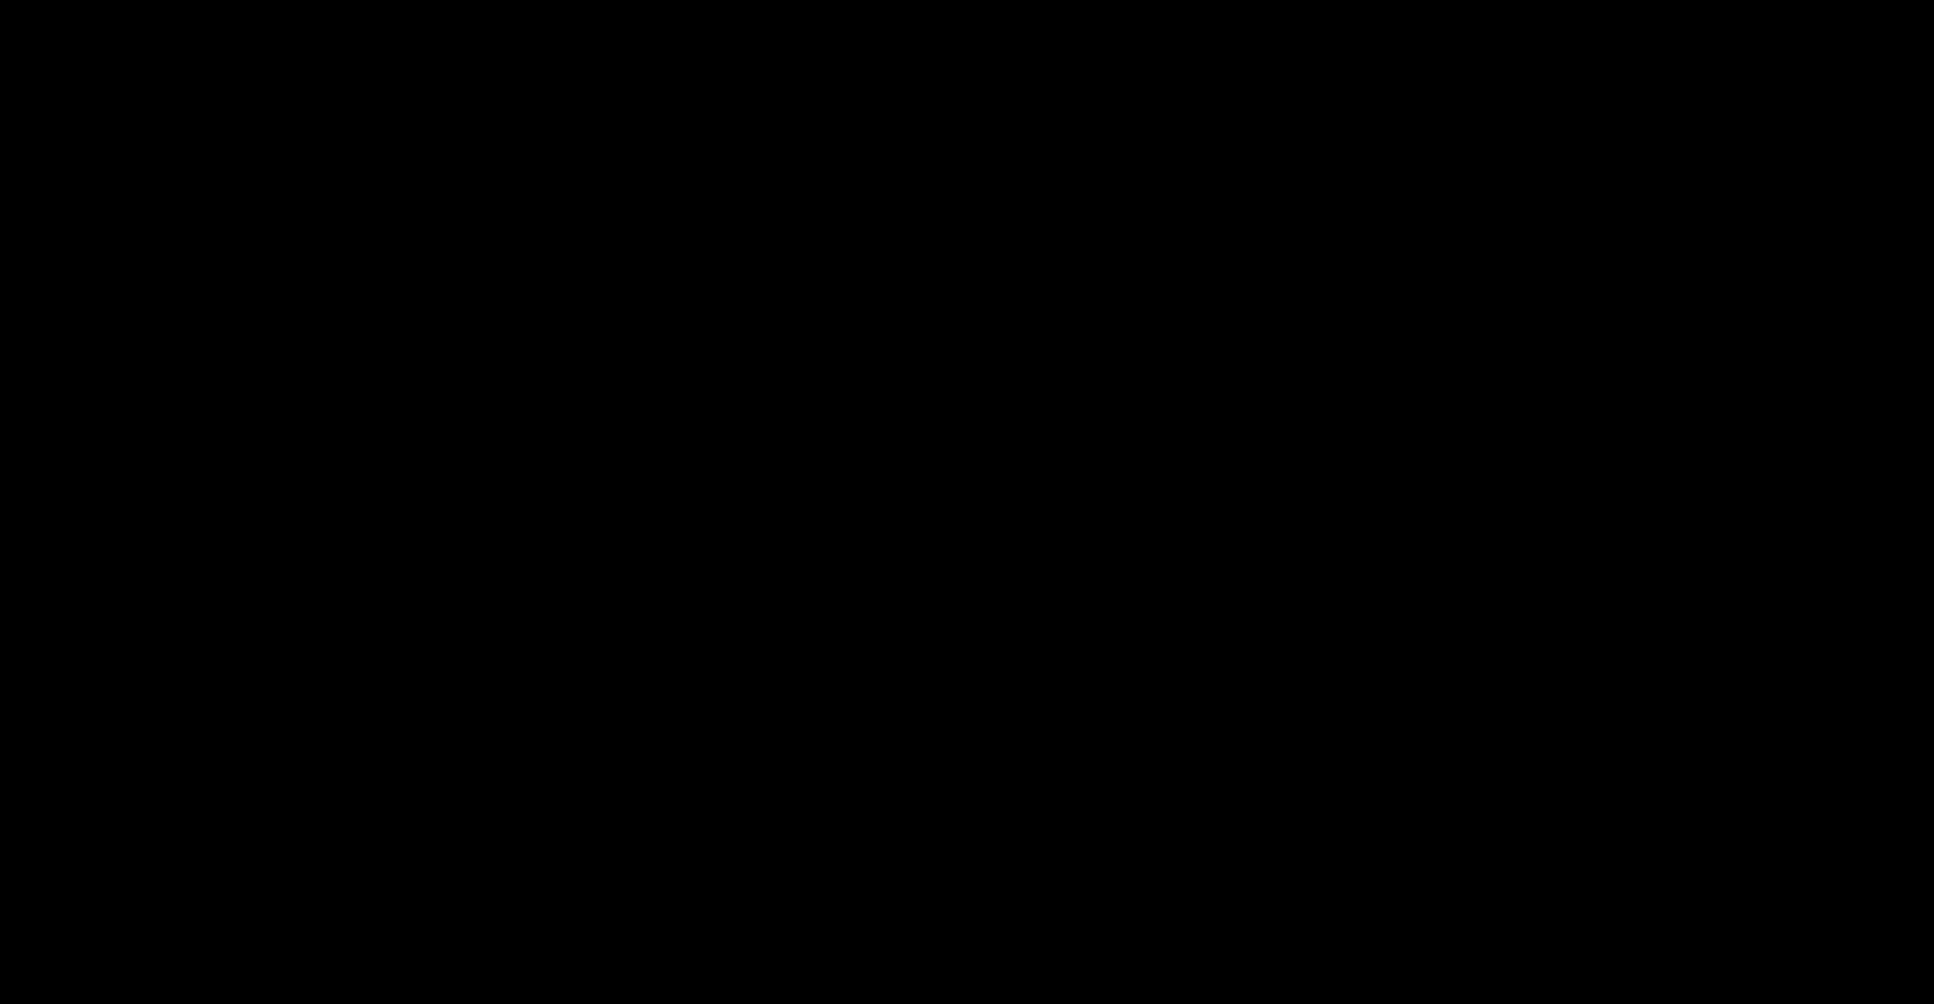

In [39]:
showall(pair['Host'], pair['id'], LG=LG1)

In [47]:
LG1[8].keys()

dict_keys(['BGG', 'neighbor', 'sats', 'subs', 'real', 'box', 'UDG', 'isLG'])

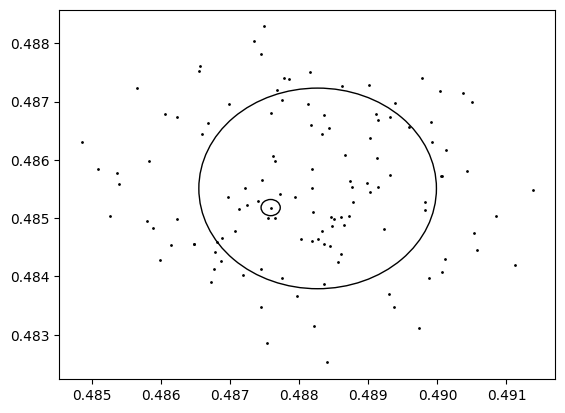

In [51]:


fig, ax = plt.subplots()
tmp = LG1[8]['subs']
ax.scatter(tmp['x'], tmp['y'], s=1, fc='k')
tmp = tmp[tmp['id'] == 21103][0]
cir = plt.Circle((tmp['x'],tmp['y']), tmp['rvir'], fc='none', ec='k')
ax.add_patch(cir)
tmp = LG1[8]['BGG']
cir = plt.Circle((tmp['x'],tmp['y']), tmp['r200_code'], fc='none', ec='k')
ax.add_patch(cir)


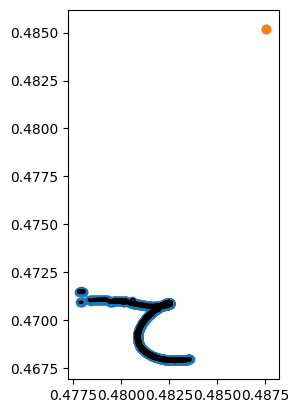

In [57]:
fig, ax = plt.subplots()
ax.set_aspect(1)
ax.scatter(branch['x'], branch['y'])
for ib in branch:
    cir = plt.Circle((ib['x'], ib['y']), ib['rvir'], ec='k', fc='none')
    ax.add_patch(cir)
ax.scatter(pair['x'], pair['y'])

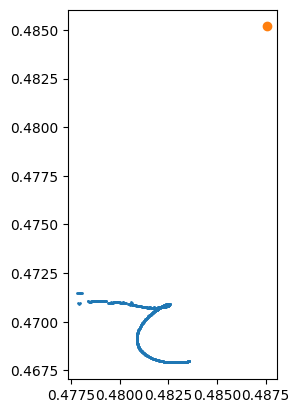

In [94]:
pair = np.random.choice(pairs1)
pair = pairs1[pairs1['id'] == 21103][0]

branch = stree1[pair['id']]
plt.scatter(branch['x'], branch['y'], s=1)
plt.scatter(pair['x'], pair['y'])
plt.gca().set_aspect(1)

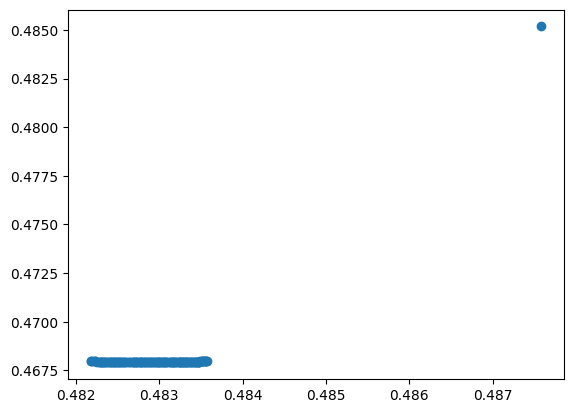

In [135]:
tmpa = pklload(f"{database1}/06a_branch_from_ptree.pickle")
tmp = tmpa[21103]
plt.scatter(tmp['x'], tmp['y'])

In [102]:
ptree_dm1 = pklload("/storage6/NewHorizon/ptree_dm/ptree_stable.pkl")
lastouts1 = nout1[snap1s.iout_avail['age'] >= np.max(snap1s.iout_avail['age']-1)]
ptree_dm1 = ptree_dm1[isin(ptree_dm1['timestep'], lastouts1)]
halos1 = pklload(f"{database1}/halo_dict.pickle")

In [138]:
tmp = ptree_dm1[ptree_dm1['timestep']==1026]
iid = 21103
last = tmp[tmp['hmid'] == iid][0]['last']
branch = ptree_dm1[ptree_dm1['last'] == last]
print((branch['hmid']))
print(tmpa[iid]['id'])
print((branch['timestep']))
print(tmpa[iid]['timestep'])

[20844 21102 21103 22388 22354 21189 21250 21152 21217 21212 21218 22381
 21190 21198 21230 21177 21232 21157 21237 21231 21203 22417 21244 21247
 21225 21162 21255 21266 21262 20813 21140 21251 21257 21236 21241 21176
 21208 21217 21285 21248 21271 21271 21230 21220 22425 21302 22394 21313
 21174 21213 21297 21290 21278 21257 21256 21200 21354 21279 21317 21189
 22500 21266 21253 21218 21230 21284 21182 21317 21296 21347 21224 21295
 21325 21313 21299 21257 21360 21353 21381 21365 21350 21287 21318 21378
 22613 21377 21343 21324 21376 21155 22330 21208 22313 22283 22324 22378
 22392 21240 22317 22377 22329 22424 21269 22430 22409 22387 22355 22312
 22442 21199 22428 22344 22379 22385 22413 22397 22416 22402 22405 22334
 21176 21164 22393 22367 22350 22048 22452 21429]
[  704   695 21103   693   699   701 20715   707   679   695   693   703
   687   678   680   694 20695   710   681 20676   683 21880   671 20769
   679   684   697 20725 20777   698   700   682 20764   686 20748   699
 

In [111]:
bb = np.argsort(-branch['timestep'])
bb = branch[bb]


In [131]:
bb[0]['id']

244922751

In [114]:
bb[0], bb[0]['last']

((4356, 1026, 2, 1386, 1386, 0, 21106, 0.8536139, 5.6854963e+09, 0.4886013, 0.48501182, 0.5012095, 147.31607, 164.65262, -176.8865, 1.1496207e+09, 8.750456e+08, 6.6509414e+08, 0.00027917, 0.00373048, 0.0076603, 0.00370822, 756.9922, -84.123886, 672.8683, 1.2445368, 71.395935, 0.0001832, 5.6854963e+09, 39519.207, 33.17851, 412.74927, 0.0001832, [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], 21105, 244922751, [[-1, -1, -1, -1], [-1, -1, -1, -1], [-1, -1, -1, -1]], 244878489, -1, 0.48615581, 0., 0, 1, 157611059, 244922751, -1, -1),
 244922751)

In [116]:
bb[1]

(4317, 1025, 2, 1390, 1390, 0, 21105, 0.85357213, 5.634593e+09, 0.48859888, 0.4850092, 0.5012088, 147.93839, 164.2487, -177.35353, 1.0569313e+09, 7.8698675e+08, 6.226351e+08, 0.00020791, 0.00372494, 0.00737977, 0.00369074, 743.2165, -84.191475, 659.025, 1.154291, 71.330444, 0.0001394, 5.634593e+09, 51475.48, 37.86631, 928.69806, 0.0001394, [[4276,   41,    0,    0], [   0,    0,    0,    0], [   0,    0,    0,    0]], 21104, 244878489, [[244922751,   2911464,        -1,        -1], [       -1,        -1,        -1,        -1], [       -1,        -1,        -1,        -1]], 239223976, 244922751, 0.38503574, 0.48615581, 1, 1, 157611059, 244922751, -1, -1)

In [117]:
bb[1]['desc']

array([[244922751,   2911464,        -1,        -1],
       [       -1,        -1,        -1,        -1],
       [       -1,        -1,        -1,        -1]])

In [118]:
bb[1]['npass']

array([[4276,   41,    0,    0],
       [   0,    0,    0,    0],
       [   0,    0,    0,    0]], dtype=int32)

In [119]:
bb[1].dtype

dtype([('nparts', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f4'), ('m', '<f4'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('vx', '<f4'), ('vy', '<f4'), ('vz', '<f4'), ('Lx', '<f4'), ('Ly', '<f4'), ('Lz', '<f4'), ('r', '<f4'), ('a', '<f4'), ('b', '<f4'), ('c', '<f4'), ('ek', '<f4'), ('ep', '<f4'), ('et', '<f4'), ('spin', '<f4'), ('sigma', '<f4'), ('rvir', '<f4'), ('mvir', '<f4'), ('tvir', '<f4'), ('cvel', '<f4'), ('rho0', '<f4'), ('rc', '<f4'), ('npass', '<i4', (3, 4)), ('hmid', '<i4'), ('id', '<i8'), ('desc', '<i8', (3, 4)), ('fat', '<i8'), ('son', '<i8'), ('score_fat', '<f8'), ('score_son', '<f8'), ('nprog', '<i8'), ('ndesc', '<i8'), ('first', '<i8'), ('last', '<i8'), ('first_rev', '<i8'), ('last_rev', '<i8')])

In [125]:
isnap = snap1s.get_snap(bb[0]['timestep'])
ipart = uhmi.HaloMaker.read_member_part(isnap, bb[0]['hmid'], galaxy=False, simple=False)
jsnap = snap1s.get_snap(bb[1]['timestep'])
jpart = uhmi.HaloMaker.read_member_part(jsnap, bb[1]['hmid'], galaxy=False, simple=False)

In [126]:
len(ipart), len(jpart)

(4356, 4317)

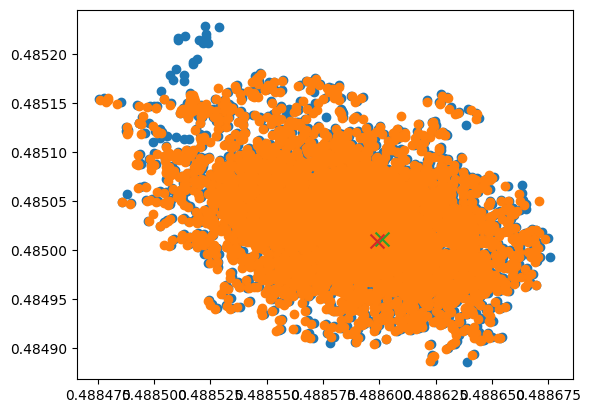

In [130]:
plt.scatter(ipart['x'], ipart['y'])
plt.scatter(jpart['x'], jpart['y'])
plt.scatter(bb[0]['x'], bb[0]['y'], marker='x', s=100)
plt.scatter(bb[1]['x'], bb[1]['y'], marker='x', s=100)

In [123]:
bb[1]['score_son']

0.48615580702257055

In [124]:
bb[0]['score_fat']

0.48615580702257055

ValueError: no field of name hmid

7.838690700530329 9.292750299916074


IndexError: index -1 is out of bounds for axis 0 with size 0

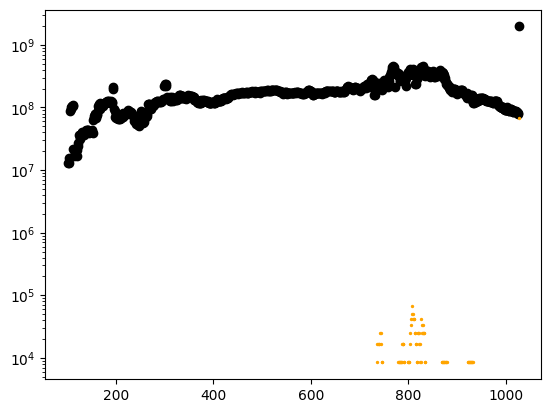

In [37]:
for pair in pairs1:
    branch = stree1[pair['id']]
    tmp = branch['insitu_vir']>0
    if(np.sum(tmp)<5):
        print(np.log10(pair['mstar_vir']), np.log10(pair['mdm_vir']))
        plt.scatter(branch['timestep'], branch['mdm_vir'], fc='k')
        plt.scatter(branch['timestep'], branch['insitu_vir'], fc='dodgerblue')
        plt.scatter(branch['timestep'], branch['mstar_vir'], fc='orange', s=2)
        plt.yscale('log')
        where = np.where(tmp)[0][-1]
        print(np.log10(np.sum(branch['insitu_vir'])), np.log10(branch[0]['mstar_vir']), branch[where]['timestep'])
        break

In [5]:
target = stree1[pairs1[0]['id']][-1]

In [6]:
snap = snap1s.get_snap(target['timestep'])
snap.set_box_halo(target, 1.5, radius_name='r')
snap.get_cell(nthread=16)
allcells = snap.cell
cells = cut_sphere(allcells, target['x'], target['y'], target['z'], target['r'])

In [7]:
import ramses_function
reload(ramses_function)
from ramses_function import *

In [8]:
# Variable in this snapshot
h0 = params('h0', snap)
aexp = params('aexp', snap)
omega_m = params('omega_m', snap)
scale_nH = params('scale_nH', snap)
nCOM = params('nCOM', snap)
d_gmc = params('d_gmc', snap)
factG = params('factG', snap)
dt_old = params('dt_old', snap)
dt_new = params('dt_new', snap)
mass_sph = params('mass_sph', snap)
localseed = params('localseed', snap)

In [9]:
d_gmc

3707.3446244493675

10.0


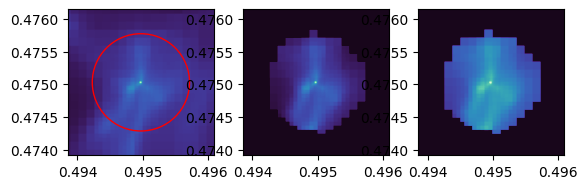

In [10]:
print(d_gmc/snap.unit['H/cc'])
cold = cells[cells['T','K'] < 1e4]
deng = cells[cells['rho','H/cc'] < d_gmc/snap.unit['H/cc']]

fig, axes = plt.subplots(1,3)
painter.draw_gasmap(snap.cell, ax=axes[0])
painter.draw_gasmap(cold, ax=axes[1])
painter.draw_gasmap(deng, ax=axes[2])
cir = plt.Circle((target['x'],target['y']), target['r'], fill=False, color='r')
axes[0].add_artist(cir)

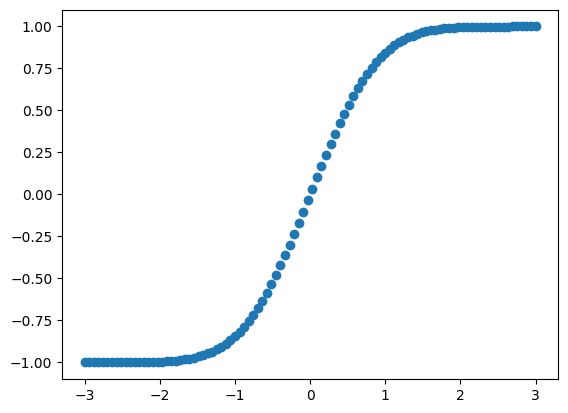

In [11]:
plt.scatter(np.linspace(-3, 3, 100), 1-erfcs(np.linspace(-3, 3, 100)))

In [12]:
def get_dt(snap, snaps):
    istep = np.where(snaps.iout_avail['iout'] == snap.iout)[0][0]
    table = snaps.iout_avail['time']
    return np.abs(table[istep-1] - table[istep])
get_dt(snap, snap1s)

0.1955601350000009

In [219]:
def get_nbor(icell, cells, return_nbor=False, buffer=0.01):
    dx = icell['dx']
    distx = np.abs(cells['x'] - icell['x'])
    disty = np.abs(cells['y'] - icell['y'])
    distz = np.abs(cells['z'] - icell['z'])
    indx = distx <= (dx/2 + cells['dx']/2)
    indy = disty <= (dx/2 + cells['dx']/2)
    indz = distz <= (dx/2 + cells['dx']/2)
    neighs = cells[indx&indy&indz]
    neighs = neighs[neighs['rho'] != icell['rho']]

    samez = (neighs['z'] <= ((icell['z'] + icell['dx']/2)*(1+buffer)))&(neighs['z'] >= ((icell['z'] - icell['dx']/2)*(1+buffer)))
    samey = (neighs['y'] <= ((icell['y'] + icell['dx']/2)*(1+buffer)))&(neighs['y'] >= ((icell['y'] - icell['dx']/2)*(1+buffer)))
    samex = (neighs['x'] <= ((icell['x'] + icell['dx']/2)*(1+buffer)))&(neighs['x'] >= ((icell['x'] - icell['dx']/2)*(1+buffer)))

    # left right
    sameyz = samey & samez
    lrs = neighs[sameyz]
    print(lrs['x'])
    ls = lrs[lrs['x'] < icell['x']]
    rs = lrs[lrs['x'] > icell['x']]
    # front back
    samezx = samez & samex
    fbs = neighs[samezx]
    fs = fbs[fbs['y'] < icell['y']]
    bs = fbs[fbs['y'] > icell['y']]
    # up down
    samexy = samex & samey
    uds = neighs[samexy]
    us = uds[uds['z'] < icell['z']]
    ds = uds[uds['z'] > icell['z']]
    if(return_nbor): return ls, rs, fs, bs, us, ds, neighs
    return ls, rs, fs, bs, us, ds

In [220]:
scale_nH

0.0016327003933974359

In [221]:
localseed = from_raw('localseed', snap, 2)
print(localseed)
localseed = from_raw('localseed', snap1, 1)
print(localseed)
localseed = from_raw('localseed', snap, 1)
print(localseed)
Seed = localseed

[3401 3435 3241 1827]
[3429 3833 3484 3977]
[3281 4041  595 2376]


In [222]:
import ramses_function
reload(ramses_function)
from ramses_function import *

In [235]:
for icell in tqdm(cells):
    if(icell['rho'] < d_gmc*19): continue
    ls,rs,fs,bs,us,ds, neighs = get_nbor(icell, cells, return_nbor=True, buffer=0)
    break
    # print(len(ls), len(rs), len(fs), len(bs), len(us), len(ds))
    # if((len(ls)==0 or len(rs)==0 or len(fs)==0 or len(bs)==0 or len(us)==0 or len(ds)==0)):
    #     print(len(ls), len(rs), len(fs), len(bs), len(us), len(ds), icell['rho'])
        # break
print(icell['rho', 'H/cc'])
ndtype = [
    ('trgv', 'f8'), ('c_s2', 'f8'), ('mach2', 'f8'), 
    ('alpha0', 'f8'), ('sigs', 'f8'), ('scrit', 'f8'), 
    ('sfr_ff', 'f8'), ('tstar', 'f8'), ('mstar', 'f8'), 
    ('nstar', 'i8'), ('dt_fine', 'f8'), ('dt_iout', 'f8'), 
    ('PoissMean', 'f8'), ('nstar_corrected', 'f8')
    ]

# The local 3D instantaneous velocity dispersion sig_g
# trgv = (sig_g)^2
#   trgv = sum( Del (curl) udx )^2
#   `star_formation.f90: federrath3`
trgv = 0
def wmean(vals,ws):
    if(len(vals)==1): return vals[0]
    return np.average(vals, weights=ws)
for val in ['vx','vy','vz']:
    d = icell['rho']
    dl = wmean( ls['rho'], ls['vol'])
    dr = wmean( rs['rho'], rs['vol'])
    df = wmean( fs['rho'], fs['vol'])
    db = wmean( bs['rho'], bs['vol'])
    du = wmean( us['rho'], us['vol'])
    dd = wmean( ds['rho'], ds['vol'])
    vl = ( dl*wmean( ls[val], ls['vol']) + icell[val]*d ) / ( dl + d )
    vr = ( dr*wmean( rs[val], rs['vol']) + icell[val]*d ) / ( dr + d )
    vf = ( df*wmean( fs[val], fs['vol']) + icell[val]*d ) / ( df + d )
    vb = ( db*wmean( bs[val], bs['vol']) + icell[val]*d ) / ( db + d )
    vu = ( du*wmean( us[val], us['vol']) + icell[val]*d ) / ( du + d )
    vd = ( dd*wmean( ds[val], ds['vol']) + icell[val]*d ) / ( dd + d )
    trgv += (vl-vr)**2 + (vf-vb)**2 + (vu-vd)**2
print(f"{trgv=:}")
print(f"{trgv/(snap.unit['km/s'])**2=:}")


# The sound speed squared c_s2
#   `star_formation.f90: federrath3`
# c_s2 = max(smallc**2, icell['P']*(gamma - 1))

# 'cs': lambda table: np.sqrt(gamma * table['P'] / table['rho'])
P = icell['P']
c_s = np.sqrt((gamma-1) * P / d)
print(c_s/snap.unit['km/s'])
c_s2 = c_s**2
print(f"{c_s2=:}")
print(f"{c_s2/(snap.unit['km/s'])**2=:}")

# Mach number
#   mach > 1: highly turbulent regions
mach2 = trgv/c_s2
print(f"{mach2=:}")

# star_formation.f90: 85
#   ! Mesh spacing in that level
ilevel = icell['level']
dx = icell['dx']
dx_loc   = dx
vol_loc = dx_loc**3
mcell = icell['rho'] * vol_loc

# The virial parameter
#   The virial parameter of a spherical gas cloud with the same mass, radius, and thermo-turbulent velocity dispersion of the gas cell
#   alpha0 = 5(trgv + c_s2) / (pi*G*rho*dx_loc**2)
#   alpha < 1 : gravitationally bound
#   `star_formation.f90: federrath3`
alpha0 = 5*(trgv + c_s2)/(np.pi * factG * icell['rho'] * dx_loc**2)
print(f"numerator: {5*(trgv + c_s2)}")
print(f"denominator: {np.pi * factG * icell['rho'] * dx_loc**2}")
print(f"{alpha0=:}")

# Variance of the logarithmic PDF
#   sigs = (sig_s)^2 = ln(1 + b^2 * M^2)
#   b=0.4: fractional amount of solenoidal to compressional modes of the turbulence
#   `star_formation.f90: federrath3`
sigs  = np.log(1.0 + 0.16*mach2)
print(f"{sigs=:}")

# The criitical densisity contrast by Padoan & Nordlund (2011)
#   `star_formation.f90: federrath3`
scrit = np.log(0.067 / theta**2 * alpha0 * mach2)
print(f"{scrit=:}")

# sigs > scrit -> star formation
# Hennebelle & Chabrier (2011)
#   `star_formation.f90: federrath3`
sfr_ff = e_cts/2*phi_t * np.exp(3/8*sigs) * (2 - erfc( (sigs-scrit)/np.sqrt(2*sigs) ))
print(f"{sfr_ff=:}")

# The local free-fall time of the gas
#   `star_formation.f90: federrath3`
tstar     = 0.5427 * np.sqrt(1/( factG*icell['rho'] )) # 0.5427 = sqrt(3pi / 32)


# Initial star particle mass
nlevelmax = snap.params['levelmax']
dx_min   = 0.5**nlevelmax
vol_min  = dx_min**snap.params['ndim']
if(m_star < 0e0): mstar = n_star/(scale_nH*aexp**3)*vol_min*fstar_min
else:
    mass_sph = from_raw('mass_sph', snap)
    mstar=m_star*mass_sph
print(f"{mstar=:}")
print(f"{mcell=:}")

nstar = 0
dt_new = from_raw('dt_new', snap)
dt = dt_new[ilevel-1]
print(dt / snap.unit['Myr'])
dt = get_dt(snap, snap1s)
print(dt / snap.unit['Myr'])
PoissMean = dt*sfr_ff/tstar*mcell/mstar
print(f"{sfr_ff/tstar*mcell/mstar=:}")
print(f"{PoissMean=:}")
# If catastrophic star formation (massive star cluster) wants to occur, we need to limit the 
# maximal mass of the star particle we want to create in a cell.
PoissMean = min(PoissMean,10.0)
print(f"{PoissMean=:}")
# Compute Poisson realisation
localseed = from_raw('localseed', snap)
nstar = poissdev(localseed,PoissMean,nstar)
print(f"{nstar=:}")
# Compute depleted gas mass
mgas      = nstar*mstar

# Security to prevent more than 90% of gas depletion
if (mgas > 0.9*mcell) :
    nstar_corrected = int(0.9*mcell/mstar)
    nstar        = nstar_corrected
print(f"{nstar=:}")





# fig, ax = plt.subplots()
# ax.scatter(neighs['x'], neighs['y'], s=5, c='k')
# for neigh in neighs:
#     rectangle = plt.Rectangle((neigh['x']-neigh['dx']/2, neigh['y']-neigh['dx']/2), neigh['dx'], neigh['dx'], fill=False, color='k', lw=0.2, ls=':')
#     ax.add_patch(rectangle)   
# for tmp in [ls, rs, fs, bs, us, ds]:
#     ax.scatter(tmp['x'], tmp['y'], s=5, c='r')
#     for neigh in tmp:
#         rectangle = plt.Rectangle((neigh['x']-neigh['dx']/2, neigh['y']-neigh['dx']/2), neigh['dx'], neigh['dx'], fill=False, color='r')
#         ax.add_patch(rectangle)
# # rectangle = plt.Rectangle((ls['x']-ls['dx']/2, ls['y']-ls['dx']/2), ls['dx'], ls['dx'], fill=False, color='r')
# # ax.add_patch(rectangle)




# ax.scatter(icell['x'], icell['y'], s=5, c='b')

# ax.set_aspect('equal')

  0%|          | 0/36202 [00:00<?, ?it/s]

[0.4950161  0.49500847]
260.74454015129487
trgv=2.023144853888543e-08
trgv/(snap.unit['km/s'])**2=254.04633000416308
2.602139937473244
c_s2=5.392316186911786e-10
c_s2/(snap.unit['km/s'])**2=6.771132254193257
mach2=37.519032337145106
numerator: 1.0385340078788304e-07
denominator: 1.620971435143146e-08
alpha0=6.4068618691428
sigs=1.946345079308468
scrit=4.996480505728272
sfr_ff=0.00851329077101038
mstar=1.16799952975498e-13
mcell=6.793259489906006e-12
0.0038378197398584485
15.240936287431166
sfr_ff/tstar*mcell/mstar=17.18010635636458
PoissMean=2.370320410230855
PoissMean=2.370320410230855
nstar=3
nstar=3


In [ ]:
np.pi * factG * icell['rho'] * dx_loc**2

1.620971435143146e-08